In [2]:
#imports
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

In [30]:
#analyze training data and derive climatology estimates
df = pd.read_csv("results_train.csv", encoding="utf-8")
df['err'] = df['xgboost_tmp2m_pred'] - df['tmp2m']
df['lon2'] = df['lon']-360
df['latlon'] = df['lat'].astype(str) + "|" + df['lon'].astype(str)
df['start_date'] = pd.to_datetime(df['start_date'])
df['month'] = pd.DatetimeIndex(df['start_date']).month
df['month2'] = df['month'].astype(str).str.zfill(2)
df['year'] = pd.DatetimeIndex(df['start_date']).year
df['yearmonth'] = df['year'].astype(str) + '-' + df['month2'].astype(str)
df['err'] = round(df['err'],3)
df['phys_err'] = round(df['phys_err'],3)

#Seasons
def season (x):
    if x in [12,1,2]:
        return 'winter'
    elif x in [3,4,5]:
        return 'spring'
    elif x in [6,7,8]:
        return 'summer'
    elif x in [9,10,11]:
        return 'fall'

#Locations
locations = pd.read_csv("locations.csv", encoding="utf-8")
locations.rename(columns={"Location": "latlon"}, inplace=True)
locations.sort_values(by=['latlon'], ascending=False)


#Map season and location and extremes
df['season'] = df['month'].apply(season)
df = pd.merge(df, locations, on='latlon')
df['heatwave'] = df['tmp2m'] >34
df['coldwave'] = df['tmp2m'] <-10

#Functions / Metrics
def mbe (x):
    return round(np.mean(x),3)

def mae (x):
    return round(np.mean(abs(x)), 3)

def sd (x):
    return round(np.std(x), 3)

In [31]:
#Drop the dates that overlap with the test set because that is used for validation
df = df[df['start_date']<'2019-01-01']
df

,Unnamed: 0,Unnamed: 0.1,key,start_date,lat,lon,xgboost_tmp2m_pred_zscore,tmp2m_daily_mean,tmp2m_daily_std,tmp2m_zscore,...,month,month2,year,yearmonth,season,State,Sub-Region,Region,heatwave,coldwave
883,0,0,2018-12-29|27.25|261.75,2018-12-29,27.25,261.75,-0.057595,14.702227,2.866412,-0.252842,...,12,12,2018,2018-12,winter,Texas,West South Central,South,False,False
884,197,197,2018-12-30|27.25|261.75,2018-12-30,27.25,261.75,-0.098113,14.775914,2.747496,-0.364047,...,12,12,2018,2018-12,winter,Texas,West South Central,South,False,False
885,394,394,2018-12-31|27.25|261.75,2018-12-31,27.25,261.75,-0.105415,14.939033,2.615850,-0.368487,...,12,12,2018,2018-12,winter,Texas,West South Central,South,False,False
886,591,0,2018-12-19|27.25|261.75,2018-12-19,27.25,261.75,0.223795,14.102848,2.503313,0.257848,...,12,12,2018,2018-12,winter,Texas,West South Central,South,False,False
887,788,197,2018-12-20|27.25|261.75,2018-12-20,27.25,261.75,0.258854,14.231063,2.352766,0.405074,...,12,12,2018,2018-12,winter,Texas,West South Central,South,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536623,140263,1181,2013-12-19|47.25|273.75,2013-12-19,47.25,273.75,-0.904409,-6.268636,3.717467,-0.955718,...,12,12,2013,2013-12,winter,Michigan,East North Central,Midwest,False,False
536624,140460,1378,2013-12-20|47.25|273.75,2013-12-20,47.25,273.75,-0.904409,-6.439524,3.732835,-0.719103,...,12,12,2013,2013-12,winter,Michigan,East North Central,Midwest,False,False
536625,140657,1575,2013-12-21|47.25|273.75,2013-12-21,47.25,273.75,-0.904409,-6.520265,3.668464,-0.743973,...,12,12,2013,2013-12,winter,Michigan,East North Central,Midwest,False,False
536626,140854,1772,2013-12-22|47.25|273.75,2013-12-22,47.25,273.75,-0.878938,-6.646918,3.681086,-0.836155,...,12,12,2013,2013-12,winter,Michigan,East North Central,Midwest,False,False


In [32]:
#Recompute climatology per karthik definition at the Month level
climatology = pd.pivot_table(data=df, index=['month2', 'latlon'], values=['tmp2m'], aggfunc=np.average)
climatology.rename(columns={'tmp2m':'climatology'}, inplace=True)
climatology = climatology.reset_index()
climatology['mll'] = climatology['month2'] + "|" + climatology['latlon']
climatology

,month2,latlon,climatology,mll
0,01,27.25|261.75,16.431501,01|27.25|261.75
1,01,27.25|277.75,18.122040,01|27.25|277.75
2,01,27.25|279.75,19.003499,01|27.25|279.75
3,01,29.25|259.75,14.299031,01|29.25|259.75
4,01,29.25|261.75,14.103348,01|29.25|261.75
...,...,...,...,...
2359,12,47.25|265.75,-12.718571,12|47.25|265.75
2360,12,47.25|267.75,-12.330801,12|47.25|267.75
2361,12,47.25|269.75,-10.662811,12|47.25|269.75
2362,12,47.25|271.75,-8.324631,12|47.25|271.75


In [33]:
#load the test set
df_test = pd.read_csv("results_test.csv", encoding="utf-8")
df_test['err'] = df_test['xgboost_tmp2m_pred'] - df_test['tmp2m']
df_test['lon2'] = df_test['lon']-360
df_test['latlon'] = df_test['lat'].astype(str) + "|" + df_test['lon'].astype(str)
df_test['start_date'] = pd.to_datetime(df_test['start_date'])
df_test['month'] = pd.DatetimeIndex(df_test['start_date']).month
df_test['month2'] = df_test['month'].astype(str).str.zfill(2)
df_test['year'] = pd.DatetimeIndex(df_test['start_date']).year
df_test['yearmonth'] = df_test['year'].astype(str) + '-' + df_test['month2'].astype(str)
df_test['err'] = round(df_test['err'],3)
df_test['phys_err'] = round(df_test['phys_err'],3)

#Seasons
def season (x):
    if x in [12,1,2]:
        return 'winter'
    elif x in [3,4,5]:
        return 'spring'
    elif x in [6,7,8]:
        return 'summer'
    elif x in [9,10,11]:
        return 'fall'

#Locations
locations = pd.read_csv("locations.csv", encoding="utf-8")
locations.rename(columns={"Location": "latlon"}, inplace=True)
locations.sort_values(by=['latlon'], ascending=False)


#Map season and location and extremes
df_test['season'] = df_test['month'].apply(season)
df_test = pd.merge(df_test, locations, on='latlon')
df_test['heatwave'] = df_test['tmp2m'] >34
df_test['coldwave'] = df_test['tmp2m'] <-10

#Functions / Metrics
def mbe (x):
    return round(np.mean(x),3)

def mae (x):
    return round(np.mean(abs(x)), 3)

def sd (x):
    return round(np.std(x), 3)

df_test['mll'] = df_test['month2'] + "|" + df_test['latlon']
df_test

,key,start_date,lat,lon,xgboost_tmp2m_pred_zscore,tmp2m_daily_mean,tmp2m_daily_std,tmp2m_zscore,tmp2m,xgboost_tmp2m_pred,...,month2,year,yearmonth,season,State,Sub-Region,Region,heatwave,coldwave,mll
0,2019-10-01|27.25|261.75,2019-10-01,27.25,261.75,1.028229,22.870967,2.045002,-0.014837,22.840626,24.973697,...,10,2019,2019-10,fall,Texas,West South Central,South,False,False,10|27.25|261.75
1,2019-10-08|27.25|261.75,2019-10-08,27.25,261.75,1.093624,21.721882,1.985609,-1.286955,19.166492,23.893391,...,10,2019,2019-10,fall,Texas,West South Central,South,False,False,10|27.25|261.75
2,2019-10-15|27.25|261.75,2019-10-15,27.25,261.75,1.043933,20.675154,2.121438,-1.040800,18.467161,22.889792,...,10,2019,2019-10,fall,Texas,West South Central,South,False,False,10|27.25|261.75
3,2019-10-22|27.25|261.75,2019-10-22,27.25,261.75,0.892237,19.451975,2.304340,-1.896681,15.081376,21.507993,...,10,2019,2019-10,fall,Texas,West South Central,South,False,False,10|27.25|261.75
4,2019-10-29|27.25|261.75,2019-10-29,27.25,261.75,0.883454,18.518180,2.384524,-1.176233,15.713424,20.624798,...,10,2019,2019-10,fall,Texas,West South Central,South,False,False,10|27.25|261.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26393,2021-06-29|47.25|273.75,2021-06-29,47.25,273.75,-0.061508,15.384313,2.808936,0.734029,17.446154,15.211542,...,06,2021,2021-06,summer,Michigan,East North Central,Midwest,False,False,06|47.25|273.75
26394,2020-07-07|47.25|273.75,2020-07-07,47.25,273.75,-0.408582,16.091479,2.732136,-0.339037,15.165182,14.975177,...,07,2020,2020-07,summer,Michigan,East North Central,Midwest,False,False,07|47.25|273.75
26395,2020-07-14|47.25|273.75,2020-07-14,47.25,273.75,-0.268441,16.598514,2.503675,-0.350005,15.722215,15.926424,...,07,2020,2020-07,summer,Michigan,East North Central,Midwest,False,False,07|47.25|273.75
26396,2020-07-21|47.25|273.75,2020-07-21,47.25,273.75,-0.357121,16.739847,2.226671,0.118659,17.004061,15.944656,...,07,2020,2020-07,summer,Michigan,East North Central,Midwest,False,False,07|47.25|273.75


In [34]:
df_test2 = pd.merge(df_test, climatology, on='mll')
df_test2.drop(columns=['month2_y','latlon_y'], axis=1, inplace=True)
df_test2 = df_test2.rename(columns={'month2_x':'month2'})
df_test2

,key,start_date,lat,lon,xgboost_tmp2m_pred_zscore,tmp2m_daily_mean,tmp2m_daily_std,tmp2m_zscore,tmp2m,xgboost_tmp2m_pred,...,year,yearmonth,season,State,Sub-Region,Region,heatwave,coldwave,mll,climatology
0,2019-10-01|27.25|261.75,2019-10-01,27.25,261.75,1.028229,22.870967,2.045002,-0.014837,22.840626,24.973697,...,2019,2019-10,fall,Texas,West South Central,South,False,False,10|27.25|261.75,20.582798
1,2019-10-08|27.25|261.75,2019-10-08,27.25,261.75,1.093624,21.721882,1.985609,-1.286955,19.166492,23.893391,...,2019,2019-10,fall,Texas,West South Central,South,False,False,10|27.25|261.75,20.582798
2,2019-10-15|27.25|261.75,2019-10-15,27.25,261.75,1.043933,20.675154,2.121438,-1.040800,18.467161,22.889792,...,2019,2019-10,fall,Texas,West South Central,South,False,False,10|27.25|261.75,20.582798
3,2019-10-22|27.25|261.75,2019-10-22,27.25,261.75,0.892237,19.451975,2.304340,-1.896681,15.081376,21.507993,...,2019,2019-10,fall,Texas,West South Central,South,False,False,10|27.25|261.75,20.582798
4,2019-10-29|27.25|261.75,2019-10-29,27.25,261.75,0.883454,18.518180,2.384524,-1.176233,15.713424,20.624798,...,2019,2019-10,fall,Texas,West South Central,South,False,False,10|27.25|261.75,20.582798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26393,2021-03-30|47.25|273.75,2021-03-30,47.25,273.75,0.115369,3.585238,1.858767,-0.964566,1.792334,3.799682,...,2021,2021-03,spring,Michigan,East North Central,Midwest,False,False,03|47.25|273.75,-0.579202
26394,2019-03-05|47.25|273.75,2019-03-05,47.25,273.75,0.186987,-0.900615,2.567989,0.050368,-0.771272,-0.420434,...,2019,2019-03,spring,Michigan,East North Central,Midwest,False,False,03|47.25|273.75,-0.579202
26395,2019-03-12|47.25|273.75,2019-03-12,47.25,273.75,0.167646,0.099325,2.329561,-0.034059,0.019982,0.489867,...,2019,2019-03,spring,Michigan,East North Central,Midwest,False,False,03|47.25|273.75,-0.579202
26396,2019-03-19|47.25|273.75,2019-03-19,47.25,273.75,0.032121,0.979251,2.224867,-0.164756,0.612692,1.050717,...,2019,2019-03,spring,Michigan,East North Central,Midwest,False,False,03|47.25|273.75,-0.579202


In [35]:
#calc clim error
df_test2['clim_err'] = df_test2['climatology'] - df_test2['tmp2m']
df_test2['ml_outperforms_climatology'] = abs(df_test2['err']) < abs(df_test2['clim_err'])
df_test2['phys_outperforms_climatology'] = abs(df_test2['phys_err']) < abs(df_test2['clim_err'])

In [36]:
df_test2

,key,start_date,lat,lon,xgboost_tmp2m_pred_zscore,tmp2m_daily_mean,tmp2m_daily_std,tmp2m_zscore,tmp2m,xgboost_tmp2m_pred,...,State,Sub-Region,Region,heatwave,coldwave,mll,climatology,clim_err,ml_outperforms_climatology,phys_outperforms_climatology
0,2019-10-01|27.25|261.75,2019-10-01,27.25,261.75,1.028229,22.870967,2.045002,-0.014837,22.840626,24.973697,...,Texas,West South Central,South,False,False,10|27.25|261.75,20.582798,-2.257828,True,False
1,2019-10-08|27.25|261.75,2019-10-08,27.25,261.75,1.093624,21.721882,1.985609,-1.286955,19.166492,23.893391,...,Texas,West South Central,South,False,False,10|27.25|261.75,20.582798,1.416305,False,True
2,2019-10-15|27.25|261.75,2019-10-15,27.25,261.75,1.043933,20.675154,2.121438,-1.040800,18.467161,22.889792,...,Texas,West South Central,South,False,False,10|27.25|261.75,20.582798,2.115637,False,True
3,2019-10-22|27.25|261.75,2019-10-22,27.25,261.75,0.892237,19.451975,2.304340,-1.896681,15.081376,21.507993,...,Texas,West South Central,South,False,False,10|27.25|261.75,20.582798,5.501422,False,True
4,2019-10-29|27.25|261.75,2019-10-29,27.25,261.75,0.883454,18.518180,2.384524,-1.176233,15.713424,20.624798,...,Texas,West South Central,South,False,False,10|27.25|261.75,20.582798,4.869374,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26393,2021-03-30|47.25|273.75,2021-03-30,47.25,273.75,0.115369,3.585238,1.858767,-0.964566,1.792334,3.799682,...,Michigan,East North Central,Midwest,False,False,03|47.25|273.75,-0.579202,-2.371536,True,True
26394,2019-03-05|47.25|273.75,2019-03-05,47.25,273.75,0.186987,-0.900615,2.567989,0.050368,-0.771272,-0.420434,...,Michigan,East North Central,Midwest,False,False,03|47.25|273.75,-0.579202,0.192070,False,False
26395,2019-03-12|47.25|273.75,2019-03-12,47.25,273.75,0.167646,0.099325,2.329561,-0.034059,0.019982,0.489867,...,Michigan,East North Central,Midwest,False,False,03|47.25|273.75,-0.579202,-0.599183,True,False
26396,2019-03-19|47.25|273.75,2019-03-19,47.25,273.75,0.032121,0.979251,2.224867,-0.164756,0.612692,1.050717,...,Michigan,East North Central,Midwest,False,False,03|47.25|273.75,-0.579202,-1.191893,True,False


In [37]:
#Functions / Metrics
def mbe (x):
    return round(np.mean(x),3)

def mae (x):
    return round(np.mean(abs(x)), 3)

def sd (x):
    return round(np.std(x), 3)

In [38]:
#Climatology comparisons by State
indexlist = ['State']

vayuhpivot = pd.pivot_table(data=df_test2, index=indexlist, values='err', aggfunc=[mbe,mae,sd])
vayuhpivot.columns = list(map("_".join, vayuhpivot.columns))
vayuhpivot.rename(columns={"mbe_err":"Vayuh MBE", "mae_err":"Vayuh MAE", "sd_err":"Vayuh SD"}, inplace=True)
vayuhpivot

physicspivot = pd.pivot_table(data=df_test2, index=indexlist, values='phys_err', aggfunc=[mbe,mae,sd])
physicspivot.columns = list(map("_".join, physicspivot.columns))
physicspivot.rename(columns={"mbe_phys_err":"Physics MBE", "mae_phys_err":"Physics MAE", "sd_phys_err":"Physics SD"}, inplace=True)
physicspivot

climpivot = pd.pivot_table(data=df_test2, index=indexlist, values='clim_err', aggfunc=[mbe,mae,sd])
climpivot.columns = list(map("_".join, climpivot.columns))
climpivot.rename(columns={"mbe_clim_err":"Climatology MBE", "mae_clim_err":"Climatology MAE", "sd_clim_err":"Climatology SD"}, inplace=True)
climpivot

chartdata = pd.merge(vayuhpivot, physicspivot, on=indexlist)
chartdata = pd.merge(chartdata, climpivot, on=indexlist)
chartdata['ml>clim'] = chartdata['Vayuh MAE'] < chartdata['Climatology MAE']
chartdata['phys>clim'] = chartdata['Physics MAE'] < chartdata['Climatology MAE']
chartdata

,Vayuh MBE,Vayuh MAE,Vayuh SD,Physics MBE,Physics MAE,Physics SD,Climatology MBE,Climatology MAE,Climatology SD,ml>clim,phys>clim
State,,,,,,,,,,,
Alabama,0.070,1.708,2.233,-3.357,6.564,7.815,-0.283,1.752,2.229,True,False
Arizona,0.192,1.606,2.052,-5.129,8.386,9.602,-0.004,1.945,2.456,True,False
Arkansas,0.614,1.731,2.337,-3.425,7.265,9.287,0.638,1.814,2.393,True,False
California,0.246,1.558,2.011,-3.913,7.453,8.953,0.673,1.785,2.208,True,False
Colorado,0.185,1.812,2.426,-2.740,7.651,10.134,-0.031,2.041,2.666,True,False
Florida,0.138,1.312,1.795,-1.843,4.125,4.935,-0.089,1.277,1.713,False,False
Georgia,0.097,1.682,2.184,-3.889,6.810,7.538,-0.314,1.658,2.095,False,False
Idaho,-0.102,1.931,2.546,-5.047,8.976,10.496,0.484,2.102,2.683,True,False
Illinois,0.610,2.120,2.779,-3.671,8.654,10.838,0.582,2.208,2.881,True,False


In [39]:
#Get shapefile into geopandas dataframe and merge in forecasts
gdf = gpd.read_file('./us_states/cb_2018_us_state_500k.shp')
gdf = gdf.drop(columns=['ALAND', 'AWATER'])
gdf = gdf.rename(columns={"NAME":"State"})
gdf = gdf.merge(chartdata, on='State')
gdf

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,State,LSAD,geometry,Vayuh MBE,Vayuh MAE,Vayuh SD,Physics MBE,Physics MAE,Physics SD,Climatology MBE,Climatology MAE,Climatology SD,ml>clim,phys>clim
0,37,01027616,0400000US37,37,NC,North Carolina,00,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ...",0.149,1.615,2.021,-4.590,7.770,8.561,-0.111,1.720,2.145,True,False
1,40,01102857,0400000US40,40,OK,Oklahoma,00,"POLYGON ((-103.00257 36.52659, -103.00219 36.6...",0.536,1.812,2.573,-2.686,7.105,9.653,0.472,1.939,2.714,True,False
2,51,01779803,0400000US51,51,VA,Virginia,00,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ...",0.194,1.736,2.232,-4.754,8.170,9.234,-0.091,1.845,2.340,True,False
3,54,01779805,0400000US54,54,WV,West Virginia,00,"POLYGON ((-82.64320 38.16909, -82.64300 38.169...",0.013,1.713,2.221,-5.200,8.864,9.944,-0.429,1.954,2.456,True,False
4,22,01629543,0400000US22,22,LA,Louisiana,00,"MULTIPOLYGON (((-88.86770 29.86155, -88.86566 ...",0.298,1.525,2.097,-2.701,6.121,7.841,0.294,1.622,2.133,True,False
5,26,01779789,0400000US26,26,MI,Michigan,00,"MULTIPOLYGON (((-83.19159 42.03537, -83.18993 ...",-0.025,2.093,2.672,-4.148,8.629,10.268,-0.548,2.336,2.869,True,False
6,16,01779783,0400000US16,16,ID,Idaho,00,"POLYGON ((-117.24267 44.39655, -117.23484 44.3...",-0.102,1.931,2.546,-5.047,8.976,10.496,0.484,2.102,2.683,True,False
7,12,00294478,0400000US12,12,FL,Florida,00,"MULTIPOLYGON (((-80.17628 25.52505, -80.17395 ...",0.138,1.312,1.795,-1.843,4.125,4.935,-0.089,1.277,1.713,False,False
8,31,01779792,0400000US31,31,NE,Nebraska,00,"POLYGON ((-104.05342 41.17054, -104.05324 41.1...",0.342,2.474,3.475,-3.892,9.549,11.835,0.353,2.494,3.488,True,False
9,53,01779804,0400000US53,53,WA,Washington,00,"MULTIPOLYGON (((-122.57039 48.53785, -122.5686...",0.039,1.920,2.643,-5.177,8.746,9.513,0.516,1.903,2.486,False,False


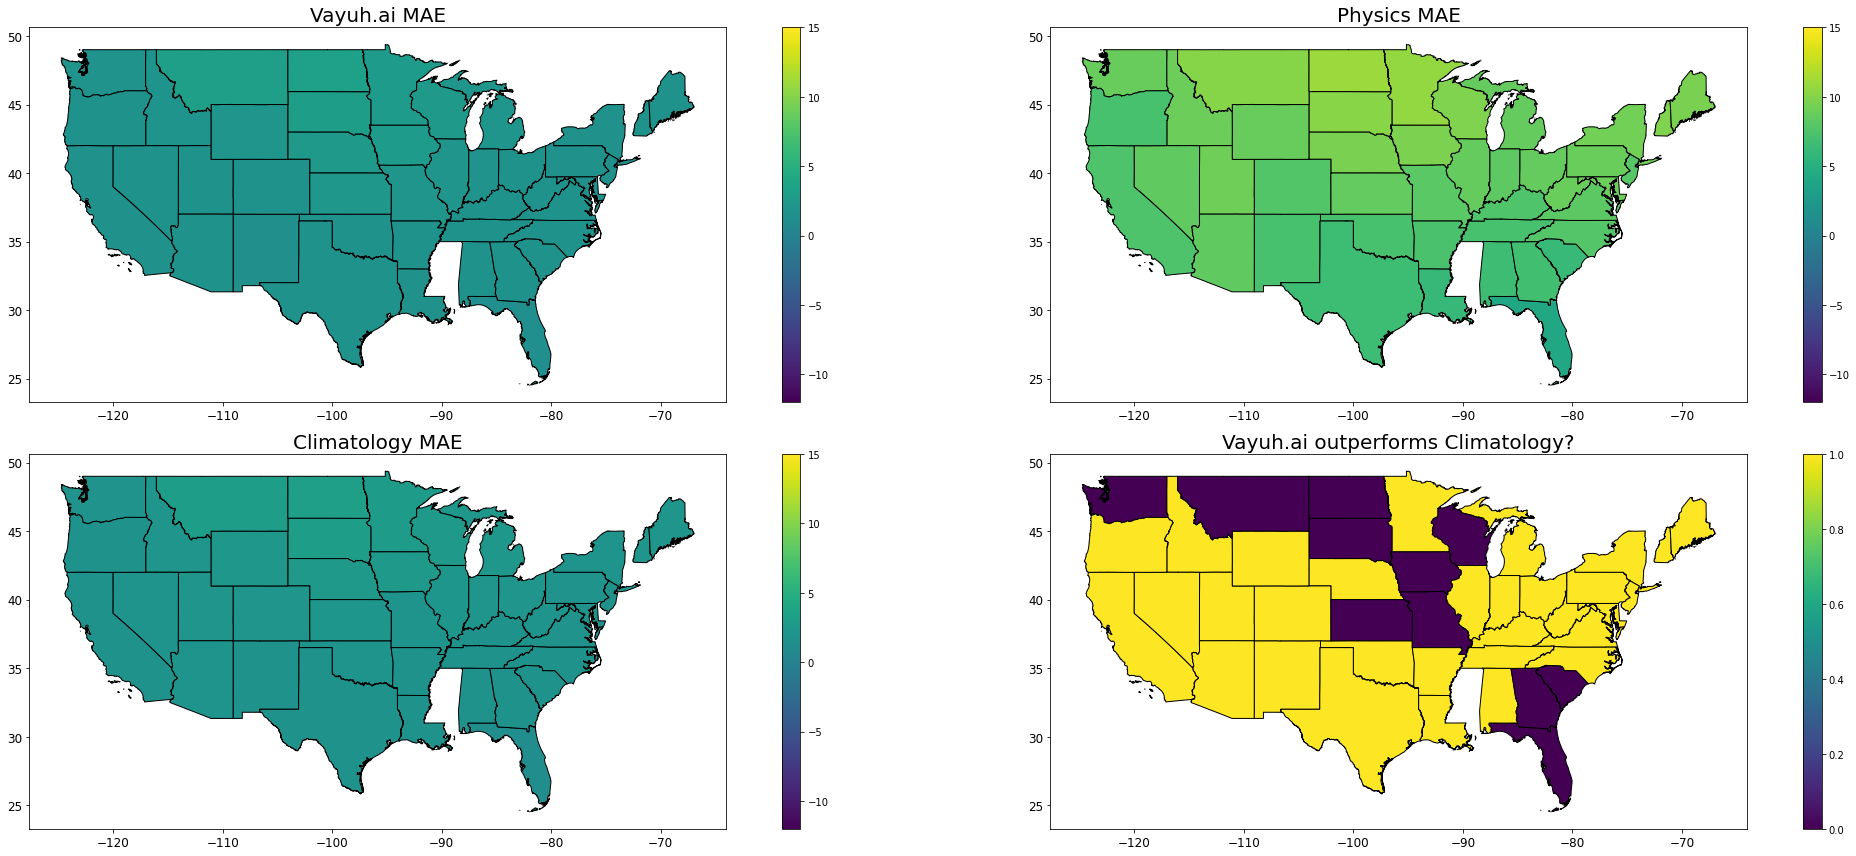

In [40]:
#Vayuh.ai MAE vs Physics MAE vs Climatology MAE
fig, axes = plt.subplots(figsize=(30,12), nrows = 2, ncols=2)
gdf.plot(ax=axes[0,0], column='Vayuh MAE', cmap='viridis', vmax=15, vmin=-12, linewidth=1, edgecolor='black', legend=True)
axes[0,0].set_title('Vayuh.ai MAE', fontsize=20)
axes[0,0].tick_params(labelsize=12)
gdf.plot(ax=axes[0,1], column='Physics MAE', cmap='viridis', vmax=15, vmin=-12, linewidth=1, edgecolor='black', legend=True)
axes[0,1].set_title('Physics MAE', fontsize=20)
axes[0,1].tick_params(labelsize=12)
gdf.plot(ax=axes[1,0], column='Climatology MAE', cmap='viridis', vmax=15, vmin=-12, linewidth=1, edgecolor='black', legend=True)
axes[1,0].set_title('Climatology MAE', fontsize=20)
axes[1,0].tick_params(labelsize=12)
gdf.plot(ax=axes[1,1], column='ml>clim', cmap='viridis', vmax=1, vmin=0, linewidth=1, edgecolor='black', legend=True)
axes[1,1].set_title('Vayuh.ai outperforms Climatology?', fontsize=20)
axes[1,1].tick_params(labelsize=12)
fig.tight_layout()

In [42]:
#Filter only for texas
texas = df_test2[df_test2['State']=='Texas']
texas

,key,start_date,lat,lon,xgboost_tmp2m_pred_zscore,tmp2m_daily_mean,tmp2m_daily_std,tmp2m_zscore,tmp2m,xgboost_tmp2m_pred,...,State,Sub-Region,Region,heatwave,coldwave,mll,climatology,clim_err,ml_outperforms_climatology,phys_outperforms_climatology
0,2019-10-01|27.25|261.75,2019-10-01,27.25,261.75,1.028229,22.870967,2.045002,-0.014837,22.840626,24.973697,...,Texas,West South Central,South,False,False,10|27.25|261.75,20.582798,-2.257828,True,False
1,2019-10-08|27.25|261.75,2019-10-08,27.25,261.75,1.093624,21.721882,1.985609,-1.286955,19.166492,23.893391,...,Texas,West South Central,South,False,False,10|27.25|261.75,20.582798,1.416305,False,True
2,2019-10-15|27.25|261.75,2019-10-15,27.25,261.75,1.043933,20.675154,2.121438,-1.040800,18.467161,22.889792,...,Texas,West South Central,South,False,False,10|27.25|261.75,20.582798,2.115637,False,True
3,2019-10-22|27.25|261.75,2019-10-22,27.25,261.75,0.892237,19.451975,2.304340,-1.896681,15.081376,21.507993,...,Texas,West South Central,South,False,False,10|27.25|261.75,20.582798,5.501422,False,True
4,2019-10-29|27.25|261.75,2019-10-29,27.25,261.75,0.883454,18.518180,2.384524,-1.176233,15.713424,20.624798,...,Texas,West South Central,South,False,False,10|27.25|261.75,20.582798,4.869374,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6561,2021-03-30|35.25|259.75,2021-03-30,35.25,259.75,-1.091037,15.831027,1.828580,-2.253912,11.709569,13.835980,...,Texas,West South Central,South,False,False,03|35.25|259.75,14.183526,2.473957,True,True
6562,2019-03-05|35.25|259.75,2019-03-05,35.25,259.75,-0.196312,11.921548,2.301581,-0.061857,11.779180,11.469720,...,Texas,West South Central,South,False,False,03|35.25|259.75,14.183526,2.404347,True,False
6563,2019-03-12|35.25|259.75,2019-03-12,35.25,259.75,-0.154134,12.783390,2.047489,0.459284,13.723769,12.467803,...,Texas,West South Central,South,False,False,03|35.25|259.75,14.183526,0.459757,False,False
6564,2019-03-19|35.25|259.75,2019-03-19,35.25,259.75,-0.135584,14.088149,2.567019,0.187006,14.568197,13.740103,...,Texas,West South Central,South,False,False,03|35.25|259.75,14.183526,-0.384671,False,False


In [45]:
#Climatology comparisons by month
indexlist = ['month2']

vayuhpivot = pd.pivot_table(data=texas, index=indexlist, values='err', aggfunc=[mbe,mae,sd])
vayuhpivot.columns = list(map("_".join, vayuhpivot.columns))
vayuhpivot.rename(columns={"mbe_err":"Vayuh MBE", "mae_err":"Vayuh MAE", "sd_err":"Vayuh SD"}, inplace=True)
vayuhpivot

physicspivot = pd.pivot_table(data=texas, index=indexlist, values='phys_err', aggfunc=[mbe,mae,sd])
physicspivot.columns = list(map("_".join, physicspivot.columns))
physicspivot.rename(columns={"mbe_phys_err":"Physics MBE", "mae_phys_err":"Physics MAE", "sd_phys_err":"Physics SD"}, inplace=True)
physicspivot

climpivot = pd.pivot_table(data=texas, index=indexlist, values='clim_err', aggfunc=[mbe,mae,sd])
climpivot.columns = list(map("_".join, climpivot.columns))
climpivot.rename(columns={"mbe_clim_err":"Climatology MBE", "mae_clim_err":"Climatology MAE", "sd_clim_err":"Climatology SD"}, inplace=True)
climpivot

chartdata2 = pd.merge(vayuhpivot, physicspivot, on=indexlist)
chartdata2 = pd.merge(chartdata2, climpivot, on=indexlist)
chartdata2['ml>clim'] = chartdata2['Vayuh MAE'] < chartdata2['Climatology MAE']
chartdata2['phys>clim'] = chartdata2['Physics MAE'] < chartdata2['Climatology MAE']
chartdata2

,Vayuh MBE,Vayuh MAE,Vayuh SD,Physics MBE,Physics MAE,Physics SD,Climatology MBE,Climatology MAE,Climatology SD,ml>clim,phys>clim
month2,,,,,,,,,,,
01,1.515,2.304,3.622,6.040,7.835,10.902,1.597,1.991,3.171,False,False
02,0.671,1.784,2.210,-0.070,2.729,3.379,0.783,2.698,3.239,True,False
03,0.056,1.252,1.600,-4.809,4.967,3.434,0.975,1.311,1.363,True,False
04,0.450,1.317,1.534,-3.528,4.105,3.984,-0.169,1.418,1.751,True,False
05,0.927,1.274,1.128,-7.469,7.661,7.291,0.500,1.326,1.571,True,False
06,0.099,0.929,1.143,-5.274,5.287,2.921,0.235,1.111,1.333,True,False
07,-0.600,1.191,1.418,-12.110,12.110,5.379,-0.291,1.139,1.333,False,False
08,-0.278,1.800,2.209,-13.361,13.361,5.387,-0.593,2.109,2.391,True,False
09,-0.187,1.841,2.236,2.051,5.117,5.404,-0.292,2.347,2.980,True,False
